# Homework 4 - Hard coding

### Libraries

In [1]:
import math 
import time
from sympy import isprime
import numpy as np

In [2]:
import hashing_lib

## 1. Hashing task!

In this task we implement an algorithm whose aim is to check very rapidly the membership of some passwords in a very very big set of passwords. In order to achive this, we define our own **bloom filter**, the implementation of whom can be found in the file *hashing_lib.py* together with the different functions the we built to hash the passwords.

The key to obtain an efficient algorithm is to choose some optimal parameters, namely the size ***m*** of the bloom filter and the number ***k*** of hash functions used in its construction. We know that the probability of getting a false positive is given by $p\approx(1-e^{-\frac{kn}{m}})^k$, where ***n*** corresponds in this case to number of passwords in the big set, that is:

In [3]:
n = sum(1 for line in open('passwords1.txt'))
n

99933038

From the estimation above, one can deduce the optimal values of *m* and *n* that can ensure a relatively small false positive error rate, say $p = 0.10$:

In [4]:
p = 0.1    # false pasitive error rate
m = math.ceil(-(n*math.log(p)/math.log(2)**2))    # optimal size of the bloom tree
k = math.ceil(m*math.log(2)/n)  # optimal number of hash functions to use
a = 20 # length of each password
print('k =', k, '\nm =',m)

k = 4 
m = 478932002


Unfortunatley, the time (and space) needed to build a bloom filter of this dimension is extremely high, therefore we chose to remodule it to a relatively smaller one occupying 1/3 of the the space of the optimal one. At the expenses, of course, of the error rate of false positives (see the section *Bonus* for more details). The new parameters are:

In [5]:
m = math.ceil(m/3)
k = math.ceil(m*math.log(2)/n)
p = pow(1 - math.exp(-k / (m/ n)), k)
print('k =', k, '\nm =',m, '\np =',p)

k = 2 
m = 159644001 
p = 0.5098715858146275


Therefore, we will use two hash functions to build a bloom filter whose size will be of around 60 Mbyte.
Moreover, in order to get a better beheaviour of the hash functions, we slightly modify further the value of *m* to the closest prime number bigger than it:

In [6]:
for i in range(m,m+1000):
    if isprime(i):
        m = i
        break
m

159644033

The four hash functions we will use belong to the class of *polynomial rolling functions*. The idea is that, given a string $s=(s_1,...,s_l)$ of lenght $l$ (where $l=20$ in this specific situation), its hash value is computed as $$h(s)=\sum_{i=0}^{l-1} a_i\text{ord}(s_i)\mod n$$ where $(a_1,...a_l)$ are coefficients randomly choosen among the prime numbers smaller than *n* and ord$(s_i)$ is just the Unicode number of single the character $s_i$ (more deteils in the skript *hashing_lib*, also for the implementation of the hash functions).

In [7]:
coeff1, coeff2 = hashing_lib.coefficients()
print('coeff1 =', coeff1, '\n')
print('coeff2 =', coeff2)

coeff1 = [3298979, 10182929, 16027373, 21630733, 36278849, 44356751, 52008127, 57884527, 65982401, 75469337, 83902037, 89081131, 98698763, 102854963, 110025277, 122671817, 132164657, 140273741, 146517127, 156161461] 

coeff2 = [3808159, 7135207, 20163461, 24835583, 30156911, 38836907, 44617561, 52740581, 65168057, 74980229, 84503059, 86719709, 97839713, 107094167, 117308203, 119061119, 132433291, 141162377, 149910701, 159443923]


Once all that all the initial parameters have been set, we have an initialized an $m$-dimensional vector of zeros ***B*** and built our bloom filter. This task particularly took a very long time of execution, around 4 hours in total.

In [ ]:
B = [0]*m                 
with open("passwords1.txt") as p1:
for index, line in enumerate(p1):
    if len(line.strip())==20:
        hashing_lib.bloom_filter_update(line, c1, c2, B, m)

Finally, we executed our query and checked how many passwords of the second set are (possibly) present in the first set as well. 

In [8]:
def BloomFilter(coeff1, coeff2, m):
    start = time.time()
    counter = 0          
    with open("passwords2.txt") as p1:
        for new_pass in p1:
            if len(new_pass.strip())==20:
                i1, i2 = hash_functions(new_pass, coeff1, coeff2, m)
                if B[i1]=='1' and B[i2]=='1':
                    counter += 1     
    end = time.time()
    tot_time = end-start
    return counter, tot_time, B

In [12]:
counter, tot_time, B = hashing_lib.BloomFilter(coeff1, coeff2, m)
print('Number of hash function used: ', k)
print('Number of duplicates detected: ', counter)
print('Probability of false positives: ', round(p, 2))
print('Execution time: ', round(tot_time/60,2), ' min')

Number of hash function used:  7
Number of duplicates detected:  19886145
Probability of false positives:  0.01
Execution time:  13.0  min


That means, 19886145 passwords (over a total of 99933038, i.e. half of them) of the second set are detected by the bloom filter to be duplicates. However, since the error rate $p$ of false positive is very high, the probability of each these detected passwords to be a true positive is only 0.49%.

### Bonus

It is not possible to provide the exact number of false positives found in our query because of the probabilistic nature of the data structure we used. The only thing we know is that the probability of a false positive when searching in the bloom filter is given approximately by $p\approx(1-e^\frac{-kn}{m})^k$. In the algorithm implemented above, this value correspond to $p\approx 0.51$, which is indeed a pretty high error rate (it actually means that each of the passwords that result positive in the query through the bloom filter have about the same probability of belonging or not to be true or false positive...). This estimate can be improved keeping the same data structure just increasing the size _m_ of the filter and consequently adjusting the number _k_ of hash functions. However, this implies that an array of extremely big size should be stored, yealding a non sense in the use that specific bloom filter, which was instead supposed to be space-efficient. As an example, one can set the parameters to get an error rate of 1%, i.e. $p=0.01$, but then the other parameters result to be:

In [10]:
n = 99933038
p = 0.01    
m = math.ceil(-(n*math.log(p)/math.log(2)**2))    
k = math.ceil(m*math.log(2)/n)
print('k =', k, '\nm =',m)

k = 7 
m = 957864004


Clearly, impleamenting a bloom filter of size $m=957864004\text{ bit}=114.19\text{ Mbyte}$ is not useful anymore. The following plot shows the relation between the error rate $p$ of false positives against the size of th bloom filter: 

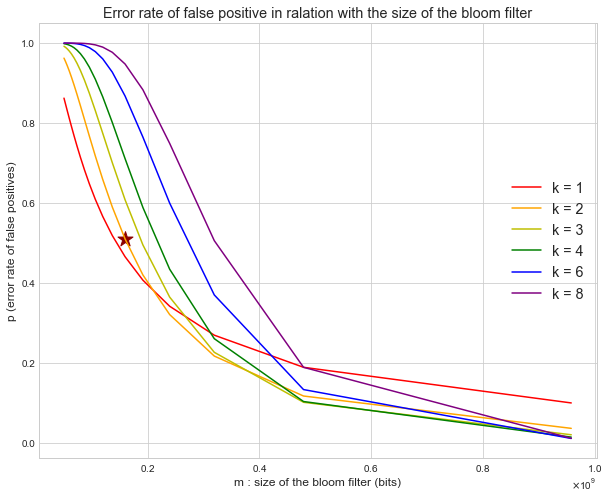

In [11]:
hashing_lib.plot_error_size()

In order to get the exact number of false positive, we can instead compare our result with the one obtainined on the same data using an "exact" data structure, such as a ***chained hash table***.

# Exercise 2 : Discussion on complexity


### Counting sort for integers

The algorithms is structured to sort a list of positive integers where the maximum $k$ of the lot is known beforehand.
It first generates the "counting" list of size $k + 1$ (from 0 to $k$). 

It proceeds then to count the occurrences of each number in the list of 
integers, this steps runs in $O(n)$.

Then, having counted those occurrences, it places them in a preallocated
array of size $n$ using slices as to not lose time. 
This step then runs in $O(k)$. 

The complexity of the whole counting sort can be defined as $O(n+k+1)$, which then becomes $O(n+k)$ after dropping the lower order term 1.

---

### Counting sort for chars

As stated in the source file, the trick here was to use the features that
python dictionaries provide: access in $O(1)$ while preserving the 
order of the keys. 

The list of letters of length $k$ was structured such as to have the
uppercase letters to be more important (i.e. they come first when sorting).

As counting sort tells us, we first have to count the occurrences of 
a given element in the range of all $k$ possible elements. This runs in
$O(k)$. The keys of the dictionary were chars from the range of letters, the occurrences where positive integers from 0 to $n$ at most.

After doing so, the letters were reinserted in another list using slices,
by following the order of the keys in the dictionary. This runs in $O(n)$.

The complexity of the counting sort for chars was also $O(n + k)$

Don 


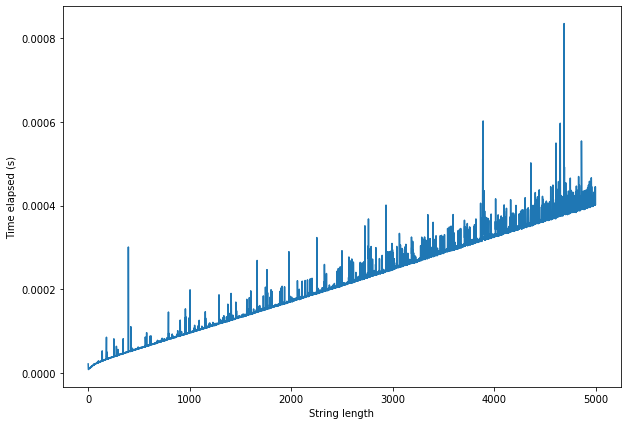

In [4]:
import sorting_lib
sorting_lib.test_counting_sort_for_integers_chars()

### Counting sort for strings (?)

This one was the trickiest, as counting sort by definition requires the
range of possible values to be known beforehand. This is not the case with
strings, where the length may vary. 

Our solution was to map strings to a single integer in a conversion
that might resemble the one used to turn numbers to one base to another (like from binary numbers to decimal). 
The problem here was that with 52 possible values for each letter required
the program to allocate a list of length $52^k$, which was consistent
with the counting sort definition but would inevitably result in an 
"OutOfMemory" error even for relatively small values of $k$. 

The other solution would be turning the counting sort in a radix sort. 

